In [ ]:
!pip install -U plotly

     |████████████████████████████████| 13.2MB 327kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
!pip install -U kaleido

     |████████████████████████████████| 74.6MB 54kB/s 


In [ ]:
# path = "/content/drive/MyDrive/209 Project/"
path = ""

In [ ]:
# Start writing code here...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates
from datetime import datetime
from datetime import date
from tqdm import tqdm
from tabulate import tabulate
plt.style.use('tableau-colorblind10')
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18

In [ ]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# # # #add one so that we could use percentage error in the loss
y_pred = np.load(path + "data/pred_result.npy")
y_test = np.load(path + "data/test_y.npy")
print(y_pred.shape, y_test.shape)

(83142,) (83142, 1)


In [ ]:
timesteps = 28
n_counties = 2682
days = 31

In [ ]:
pred_county_day = y_pred.reshape(n_counties, days)
print(pred_county_day.shape)


(2682, 31)


In [ ]:
temp_static = pd.read_csv(path + "data/temp_static.csv")
temp_static['fip'] = temp_static['fip'].apply(lambda x: str(int(x)).zfill(5))
temp_static["date"] = temp_static["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
temp_static.shape

(490806, 22)

In [ ]:
fips = temp_static['fip'].unique()
last_day_confirmed = temp_static[temp_static["date"] == date(2020, 9, 30)]["daily_confirmed"].values
test_data = temp_static[temp_static["date"] > date(2020, 9, 30)]

In [ ]:
test_data.head()

,fip,County Name,State,date,daily_confirmed,new_cases,trip_ratio,short_trip_ratio,med_trip_ratio,long_trip_ratio,avg_stay_at_home_ratio,log_new_cases,mean_neighbor_daily_confirmed,mean_neightbor_new_cases,neighbor_log_new_cases,over_65_percent,no_diploma_percent,no_insurance_percent,unemployed_percent,poverty_percent,over_65_percent.1,beds_per_1000
152,01001,Autauga County,AL,2020-10-01,1798,7.0,3.040053,0.717074,0.304579,0.029646,0.163181,2.079442,2056.000000,7.000000,2.079442,-0.774663,-0.166213,-0.644388,-0.372038,-0.376802,-0.774663,-0.111074
153,01001,Autauga County,AL,2020-10-02,1805,7.0,3.220967,0.742971,0.276164,0.022587,0.177281,2.079442,2070.666667,14.666667,2.751535,-0.774663,-0.166213,-0.644388,-0.372038,-0.376802,-0.774663,-0.111074
154,01001,Autauga County,AL,2020-10-03,1818,13.0,2.868150,0.762441,0.251693,0.030087,0.196399,2.639057,2087.666667,17.000000,2.890372,-0.774663,-0.166213,-0.644388,-0.372038,-0.376802,-0.774663,-0.111074
155,01001,Autauga County,AL,2020-10-04,1828,10.0,2.572634,0.747625,0.252816,0.039842,0.197389,2.397895,2094.000000,6.333333,1.992430,-0.774663,-0.166213,-0.644388,-0.372038,-0.376802,-0.774663,-0.111074
156,01001,Autauga County,AL,2020-10-05,1831,3.0,2.734789,0.706248,0.316256,0.030232,0.221381,1.386294,2101.333333,7.333333,2.120264,-0.774663,-0.166213,-0.644388,-0.372038,-0.376802,-0.774663,-0.111074


# Import policy coefficients

In [ ]:
policy_coefs = pd.read_csv(path + "data/policy_causal_df.csv")
print(policy_coefs.shape)
policy_coefs.head()

(8310, 6)


,Unnamed: 0,Date,State,Restaurant Limits_Closed Except for Takeout/Delivery,Stay at Home Order_Rolled Back to High Risk Groups,Mandatory Quarantine for Travelers_From Certain States (New)
0,0,2020-06-04,AK,-0.009009,-0.005006,-0.005715
1,1,2020-06-05,AK,-0.009009,-0.005006,-0.005715
2,2,2020-06-06,AK,-0.009009,-0.005006,-0.005715
3,3,2020-06-07,AK,-0.009009,-0.005006,-0.005715
4,4,2020-06-08,AK,-0.009009,-0.005006,-0.005715


In [ ]:
policy_coefs["date"] = policy_coefs["Date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

In [ ]:
county_state_fip  = pd.read_csv(path + "data/county_state_fip.csv")
county_state_fip['fip'] = county_state_fip['fip'].apply(lambda x: str(int(x)).zfill(5))
print(county_state_fip.shape)

(2682, 3)


In [ ]:
county_policy_coefs = policy_coefs.merge(county_state_fip, on = "State")
test_county_policy = county_policy_coefs[(county_policy_coefs["date"]>=date(2020,10,1)) & (county_policy_coefs["date"] < date(2020,11,1))]
test_county_policy = test_county_policy.drop(columns = "Unnamed: 0").sort_values(by = "Date")
print(test_county_policy.shape)
test_county_policy.head(2)

(83142, 8)


,Date,State,Restaurant Limits_Closed Except for Takeout/Delivery,Stay at Home Order_Rolled Back to High Risk Groups,Mandatory Quarantine for Travelers_From Certain States (New),date,fip,County Name
2023,2020-10-01,AK,-0.009009,-0.005006,-0.005715,2020-10-01,02013,Aleutians East Borough
398331,2020-10-01,VA,-0.009009,-0.005006,-0.005715,2020-10-01,51017,Bath County


In [ ]:
test_county_policy.describe()

,Restaurant Limits_Closed Except for Takeout/Delivery,Stay at Home Order_Rolled Back to High Risk Groups,Mandatory Quarantine for Travelers_From Certain States (New)
count,8.314200e+04,83142.000000,83142.000000
mean,-9.009015e-03,-0.004226,-0.005370
std,1.471748e-14,0.002684,0.001956
min,-9.009015e-03,-0.005006,-0.005715
25%,-9.009015e-03,-0.005006,-0.005715
50%,-9.009015e-03,-0.005006,-0.005715
75%,-9.009015e-03,-0.005006,-0.005715
max,-9.009015e-03,0.005006,0.005715


In [ ]:
policy_names = ['Restaurant Limits_Closed Except for Takeout/Delivery',
                'Stay at Home Order_Rolled Back to High Risk Groups',
                'Mandatory Quarantine for Travelers_From Certain States (New)']

In [ ]:
policy_short_names = ['restaurant limits',
                'stay at home order',
                'mandatory quarantine']

# Calculate prediction, MAPE and RMSE for RNN

In [ ]:
def cal_mape(y, y_pred):
    zero_idx = np.where(y == 0)
    non_zero_idx = np.nonzero(y)
    zero_y = y[zero_idx]
    zero_y_pred = y_pred[zero_idx]

    non_zero_y = y[non_zero_idx]
    non_zero_y_pred = y_pred[non_zero_idx]
    # 

    zero_sum = np.sum(zero_y != zero_y_pred)
    non_zero_sum = np.sum(np.abs((non_zero_y - non_zero_y_pred)/non_zero_y))
    # print(zero_sum, non_zero_sum)
    return (zero_sum + non_zero_sum)/len(y)

In [ ]:
def generate_confirmed_cases_log(log_new, last_day_confirmed):
    new_cases = np.exp(log_new) - 1 

    pred_confirmed = new_cases.copy()
    pred_confirmed[0] = pred_confirmed[0] + last_day_confirmed
    pred_confirmed = pred_confirmed.cumsum()
    return pred_confirmed

In [ ]:
def generate_confirmed_cases_gr(growth_rate, last_day_confirmed, n_days):
    ratio = growth_rate + 1 
    pred_confirmed = [last_day_confirmed]
    for i in range(n_days):
        pred_confirmed.append(pred_confirmed[-1]*ratio[i]) 
    return np.array(pred_confirmed[1:])

In [ ]:
x = np.array([1, -1, 2])
y = np.array([1, 3, 2])
x[x<y]

array([-1])

In [ ]:
predictions = [[],[],[],[]]
mapes_rnn = []
negative_policy_counties = [[],[],[]]
positive_policy_counties = [[],[],[]]
for i in tqdm(range(len(fips))):
    test_confirmed_i = test_data[test_data["fip"] == fips[i] ]["daily_confirmed"].values
    rnn_log_new  = pred_county_day[i] 
    last_day_confir = last_day_confirmed[i]
    pred_rnn = generate_confirmed_cases_log(rnn_log_new, last_day_confir)
    predictions[0].append(pred_rnn)


    pred_new_cases = np.array([pred_rnn[0]- last_day_confir] + list(np.diff(pred_rnn)))
    
    pred_growth_rate = pred_new_cases/pred_rnn
    # print("original growth:", pred_growth_rate)
    
    mapes_rnn.append(cal_mape(test_confirmed_i, pred_rnn))

    
    for j in range(len(policy_names)):
        policy = policy_names[j]
        policy_growth_coef= test_county_policy[test_county_policy["fip"] ==fips[i]][policy].values
        # print("policy:",policy_growth_coef)
        new_growth_rate = pred_growth_rate + policy_growth_coef


        pred_policy = generate_confirmed_cases_gr(new_growth_rate, last_day_confir, 31)
        negativeness = len(pred_policy[pred_policy>pred_rnn])/31
        if negativeness > 0.5:
              negative_policy_counties[j].append(i)
        else:
              positive_policy_counties[j].append(i)
        # print(pred_policy)
        # print(test_confirmed_i)
        # print(test_confirmed_i.shape)
        predictions[j+1].append(pred_policy)
        

100%|██████████| 2682/2682 [01:08<00:00, 39.08it/s]


In [ ]:
avg_mape_rnn = np.mean(mapes_rnn)
print("The average mape of RNN is %.4f"%(avg_mape_rnn))

The average mape of RNN is 0.0751


In [ ]:
def cal_rmse(y_true,y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

In [ ]:
def cal_rmse_county(pred_county, pred_col=None):
    rmses = []
    
    for i in tqdm(range(len(fips))):
        if not pred_col:
            pred_i = pred_county[i]
        else:
            pred_i = pred_county[pred_county["fip"] == fips[i] ][pred_col].values
        true_i = test_data[test_data["fip"] == fips[i] ]["daily_confirmed"].values
        rmse = cal_rmse(true_i, pred_i)
        rmses.append(rmse)
    return rmses

In [ ]:
rnn_rmse = cal_rmse_county(predictions[0])

100%|██████████| 2682/2682 [00:18<00:00, 148.50it/s]


In [ ]:
avg_rmse_rnn = np.mean(rnn_rmse)
print("The rmse for rnn is %.4f"%(avg_rmse_rnn))

The rmse for rnn is 132.3545


# Get MAPE for naive, seir and ensembled models

In [ ]:
naive_per_county = pd.read_csv(path + "data/naive_model_per_county.csv")
print(naive_per_county.shape)
naive_per_county.head(2)

(2682, 5)


,fip,County Name,State,pred_error,iter_pred_error
0,1001,Autauga County,AL,0.002414,0.007956
1,1003,Baldwin County,AL,0.005537,0.026249


In [ ]:
seir_per_county = pd.read_csv(path + "data/seir_per_county.csv")
seir_per_county.head(2)

,fip,County Name,State,seir_pred_error,fit_error,ensemble_error
0,1001,Autauga County,AL,0.052647,0.004449,0.052647
1,1003,Baldwin County,AL,0.064350,0.010308,0.064350


In [ ]:
avg_mape_naive = np.mean(naive_per_county["iter_pred_error"])
avg_mape_seir = np.mean(seir_per_county["seir_pred_error"])
avg_mape_seir_ens = np.mean(seir_per_county["ensemble_error"])

In [ ]:
mapes = [avg_mape_naive, avg_mape_seir, avg_mape_seir_ens, avg_mape_rnn]
print("The mape for naive model, seir, ensembled seir and rnn are %.4f, %.4f, %.4f, %.4f respectively"%(avg_mape_naive, avg_mape_seir, avg_mape_seir_ens, avg_mape_rnn))

The mape for naive model, seir, ensembled seir and rnn are 0.3355, 0.5568, 0.1387, 0.0751 respectively


In [ ]:
naive_pred = pd.read_csv(path + "data/naive_all_preds_test.csv")
naive_pred['date'] = naive_pred['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d').date())
naive_pred['fip'] = naive_pred['fip'].apply(lambda x: str(int(x)).zfill(5))
print(naive_pred.shape)
naive_pred.head(2)

(83142, 28)


,fip,County Name,State,date,daily_confirmed,confirmed_lag_1,confirmed_lag_2,confirmed_lag_3,confirmed_lag_4,confirmed_lag_5,confirmed_lag_6,confirmed_lag_7,STR_lag_1,STR_lag_2,STR_lag_3,STR_lag_4,STR_lag_5,STR_lag_6,STR_lag_7,SAH_lag_1,SAH_lag_2,SAH_lag_3,SAH_lag_4,SAH_lag_5,SAH_lag_6,SAH_lag_7,pred,iter_pred
0,01001,Autauga County,AL,2020-10-01,1798,1791.0,1787.0,1785.0,1773.0,1764.0,1757.0,1715.0,0.706109,0.702025,0.733724,0.764412,0.766660,0.706967,0.719653,0.198630,0.176795,0.173342,0.212208,0.198504,0.159170,0.167155,1806.088051,1806.088051
1,01001,Autauga County,AL,2020-10-02,1805,1798.0,1791.0,1787.0,1785.0,1773.0,1764.0,1757.0,0.717074,0.706109,0.702025,0.733724,0.764412,0.766660,0.706967,0.163181,0.198630,0.176795,0.173342,0.212208,0.198504,0.159170,1808.137422,1817.972194


In [ ]:
seir_pred = pd.read_csv(path + "data/seir_all_preds_test.csv")
seir_pred['date'] = seir_pred['date'].apply(lambda x: datetime.strptime(str(x)+"20", '%m/%d/%Y').date())
seir_pred['fip'] = seir_pred['fip'].apply(lambda x: str(int(x)).zfill(5))

seir_pred.head(2)

,fip,County Name,State,date,seir_orig_pred,seir_ensemble_pred,daily_confirmed
0,01001,Autauga County,AL,2020-10-01,1828.482149,1828.482149,1798
1,01001,Autauga County,AL,2020-10-02,1843.326091,1843.326091,1805


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

This function is deprecated. Please call randint(1, 2682 + 1) instead



[  70 2668 1014]


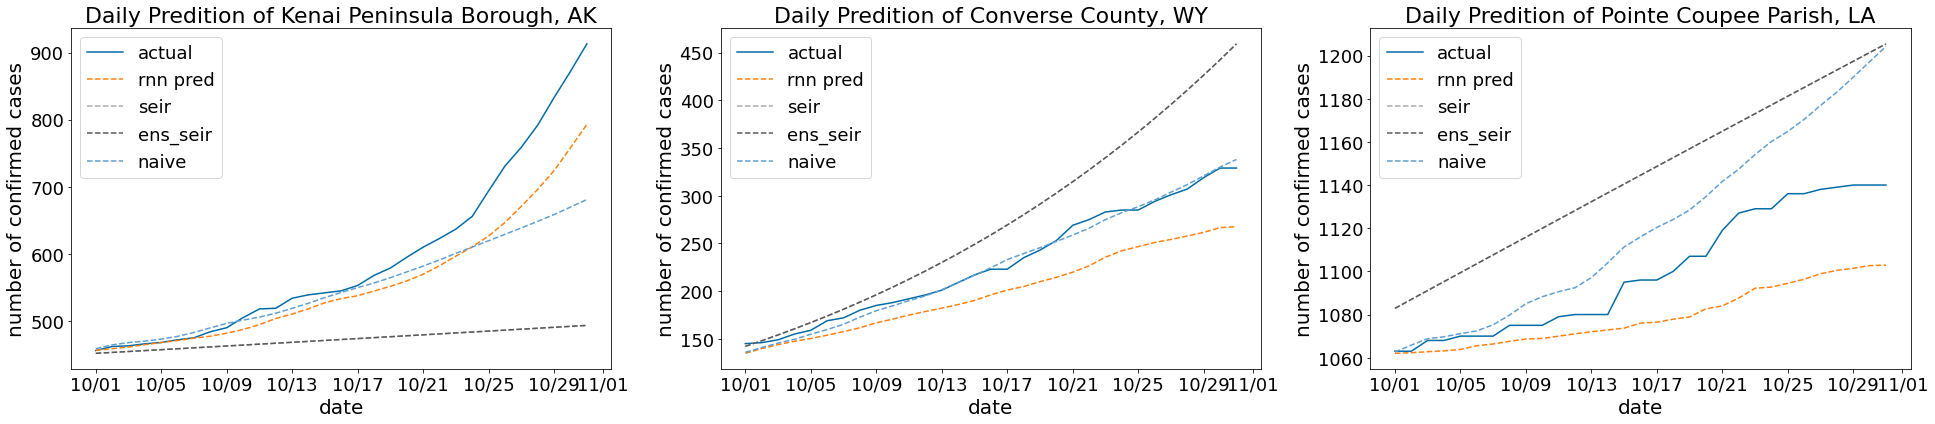

In [ ]:
size = 3
random_counties =  np.random.random_integers(len(fips), size=size)  #np.argsort(mapes_rnn)[50:53]
print(random_counties)
fig = plt.figure(figsize = (27,6))
pos = 0
for i in random_counties:
    fip = fips[i] 
    x = test_data[test_data["fip"] == fip ]["date"].values
    state_name = county_state_fip[county_state_fip["fip"] == fip]['State'].values[0]
    county_name = county_state_fip[county_state_fip["fip"] == fip]['County Name'].values[0]

    ax = fig.add_subplot(1,size,pos+1)
    formatter = mdates.DateFormatter("%m/%d")
    ax.xaxis.set_major_formatter(formatter)
  
    
    ax.plot(x, test_data[test_data["fip"] == fip]["daily_confirmed"].values, label = "actual")
    ax.plot(x, predictions[0][i], label = "rnn pred", linestyle = "--")
    
    ax.plot(x, seir_pred[seir_pred["fip"] == fip]["seir_orig_pred"].values, label = "seir", linestyle = "--")
    ax.plot(x, seir_pred[seir_pred["fip"] == fip]["seir_ensemble_pred"].values, label = "ens_seir", linestyle = "--")
    ax.plot(x, naive_pred[naive_pred["fip"] == fip]["iter_pred"].values, label = "naive", linestyle = "--")

    ax.legend(loc = "upper left",prop={'size': 18})
    ax.set_title("Daily Predition of %s, %s"%(county_name, state_name), fontsize=22)
    ax.set_xlabel("date", fontsize=20)
    ax.set_ylabel("number of confirmed cases",fontsize=20)

    pos += 1
plt.tight_layout()
fig.savefig("/content/drive/MyDrive/209 Project/graphs/comparison_pred.png", dpi = 200)  

In [ ]:
naive_rmse = cal_rmse_county(naive_pred, "iter_pred")
seir_rmse = cal_rmse_county(seir_pred, "seir_orig_pred")
seir_ens_rmse = cal_rmse_county(seir_pred, "seir_ensemble_pred")

100%|██████████| 2682/2682 [00:34<00:00, 76.65it/s]


In [ ]:
avg_rmse_naive = np.mean(naive_rmse)
avg_rmse_seir = np.mean(seir_rmse)
avg_rmse_seir_ens = np.mean(seir_ens_rmse)

In [ ]:
rmses = [avg_rmse_naive, avg_rmse_seir, avg_rmse_seir_ens, avg_rmse_rnn]
print("The rmse for naive model, seir, ensembled seir and rnn are %.4f, %.4f, %.4f, %.4f respectively"%(avg_rmse_naive, avg_rmse_seir, avg_rmse_seir_ens, avg_rmse_rnn))

The rmse for naive model, seir, ensembled seir and rnn are 126.8560, 288.2011, 159.5458, 132.3545 respectively


In [ ]:
comparison = pd.DataFrame([mapes, rmses]).round(3)
comparison["metrics"] = ["MAPE", "RMSE"]
comparison = comparison.set_index("metrics")
comparison.columns = ["naive", "SEIR","ensembled SEIR", "RNN"]

In [ ]:
print(tabulate(comparison.T, headers=comparison.index, tablefmt="pretty"))

+----------------+-------+---------+
|                | MAPE  |  RMSE   |
+----------------+-------+---------+
|     naive      | 0.335 | 126.856 |
|      SEIR      | 0.557 | 288.201 |
| ensembled SEIR | 0.139 | 159.546 |
|      RNN       | 0.075 | 132.354 |
+----------------+-------+---------+


In [ ]:
print(tabulate(comparison, headers=comparison.columns, tablefmt="latex"))

\begin{tabular}{lrrrr}
\hline
      &   naive &    SEIR &   ensembled SEIR &     RNN \\
\hline
 MAPE &   0.335 &   0.557 &            0.139 &   0.075 \\
 RMSE & 126.856 & 288.201 &          159.546 & 132.354 \\
\hline
\end{tabular}


# Plot heatmap of MAPE at different counties

In [ ]:
from plotly.figure_factory._county_choropleth import create_choropleth
import plotly.express as px
from plotly.subplots import make_subplots
import plotly
from urllib.request import urlopen
import json

In [ ]:
# load counties
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [ ]:
mape_df = pd.DataFrame([mapes_rnn, naive_per_county["iter_pred_error"].values, seir_per_county["seir_pred_error"].values,seir_per_county["ensemble_error"].values]).T
mape_df["fip"] = fips
mape_df.columns = ["rnn","naive","seir","ens_seir","fip"]
mape_df["county"] = naive_per_county["County Name"].values
mape_df["state"] = naive_per_county["State"].values
print(mape_df.shape)
mape_df.head(2)

(2682, 7)


,rnn,naive,seir,ens_seir,fip,county,state
0,0.020155,0.007956,0.052647,0.052647,01001,Autauga County,AL
1,0.055404,0.026249,0.064350,0.064350,01003,Baldwin County,AL


In [ ]:
mape_df.describe()

,rnn,naive,seir,ens_seir
count,2682.000000,2682.000000,2682.000000,2682.000000
mean,0.075125,0.335478,0.556756,0.138746
std,0.148321,1.917406,5.126848,0.634231
min,0.001091,0.000942,0.000000,0.000000
25%,0.019722,0.027073,0.030745,0.030706
50%,0.044206,0.063100,0.064669,0.064363
75%,0.093347,0.146533,0.146423,0.145174
max,4.103221,49.623917,90.100935,27.155876


In [ ]:
# mape map visualization
fig = px.choropleth(mape_df, 
                    geojson=counties, 
                    locations="fip", color='rnn',
                           
                           range_color=(0, 0.5),
                           scope="usa",
                          #  labels={'county', 'state'},
                           
                          )
fig.update_layout(title_text = 'MAPE of RNN at Different Counties', title_x=0.5,)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig.write_image(path + 'graphs/mape_rnn_map.png',  format = "png", scale=2, engine="kaleido")

In [ ]:
col_names = ["seir", "ens_seir","naive"]
model_names = ["SEIR", "Ensembled SEIR","Naive"]
for i in range(3):
    fig = px.choropleth(mape_df, 
                        geojson=counties, 
                        locations="fip", color=col_names[i], 
                        range_color=(0, 0.5),
                        scope="usa",
                          )
    fig.update_layout(title_text = 'MAPE of %s Model at Different Counties'%(model_names[i]), title_x=0.5,)
    fig.write_image(path + 'graphs/mape_%s_map.png'%(col_names[i]),  format = "png", scale=2, engine="kaleido")


# Plot Policy Effects

In [ ]:
neg_counties_total = negative_policy_counties[0] and negative_policy_counties[1] and negative_policy_counties[2]
print("The number of common counties in three negative lists are:", len(neg_counties_total))

The number of common counties in three negative lists are: 83


In [ ]:
pos_counties_total = positive_policy_counties[0] or positive_policy_counties[1] or positive_policy_counties[2]
print("The number of common counties in three positive lists are:", len(pos_counties_total))

The number of common counties in three positive lists are: 2680


In [ ]:
# print(plt.style.available)

In [ ]:
def draw_policy_effect_graph(counties, model_pred, neg_pos, size):
    random_counties = np.random.choice(counties, size=size)  #np.argsort(mapes[0])[:3] #
    print(random_counties)
    fig = plt.figure(figsize = (27,6))
    pos = 0
    for i in random_counties:
        fip = fips[i] 
        x = test_data[test_data["fip"] == fip ]["date"].values
        state_name = county_state_fip[county_state_fip["fip"] == fip]['State'].values[0]
        county_name = county_state_fip[county_state_fip["fip"] == fip]['County Name'].values[0]

        ax = fig.add_subplot(1,size,pos+1)
        formatter = mdates.DateFormatter("%m/%d")
        ax.xaxis.set_major_formatter(formatter)
  
        ax.plot(x, model_pred[i], label = "rnn pred", linestyle = "-")
        ax.plot(x, test_data[test_data["fip"] == fip]["daily_confirmed"].values, label = "actual")

        for j in range(3):
            policy_pred = predictions[j+1][i]
            ax.plot(x, policy_pred, label = policy_short_names[j], linestyle = "--")

        ax.legend(loc = "upper left",prop={'size': 18})
        ax.set_title("Policy Effect on %s, %s"%(county_name, state_name), fontsize=22)
        ax.set_xlabel("date", fontsize=20)
        ax.set_ylabel("confirmed cases",fontsize=20)

        pos += 1
    plt.tight_layout()
    fig.savefig("/content/drive/MyDrive/209 Project/graphs/lstm_policy_%s.png"%(neg_pos), dpi = 200)  


[1396 1552 1822]
[1574 1608 1622]


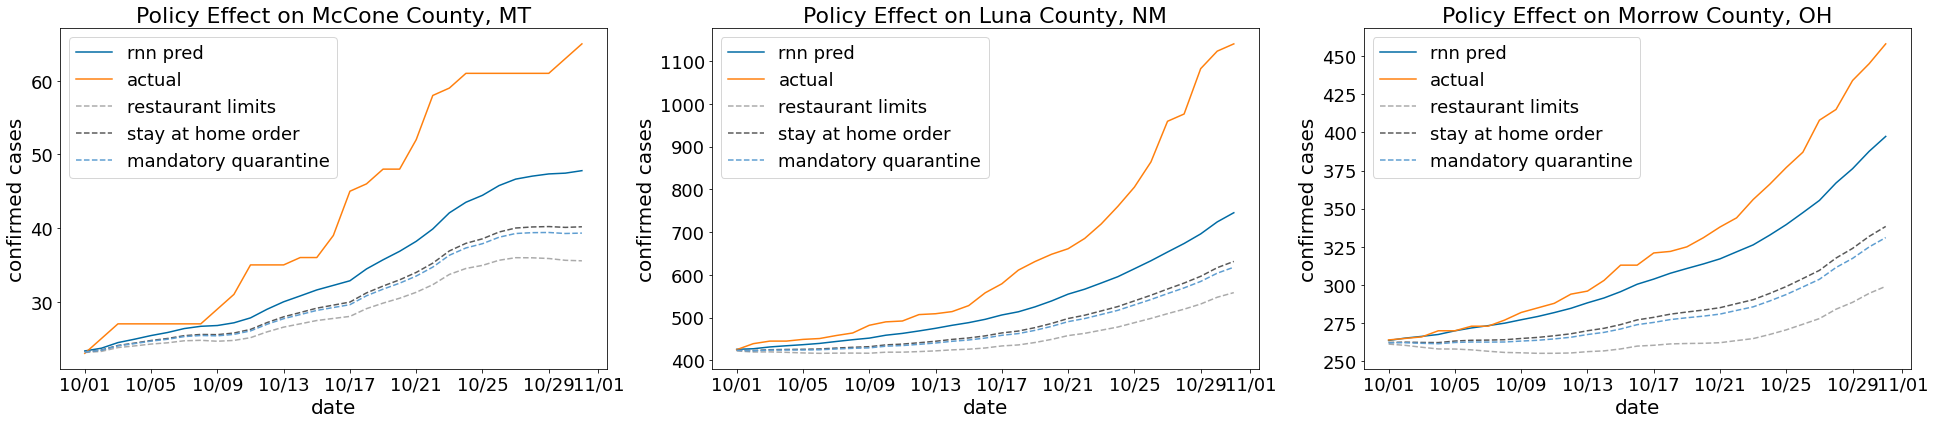

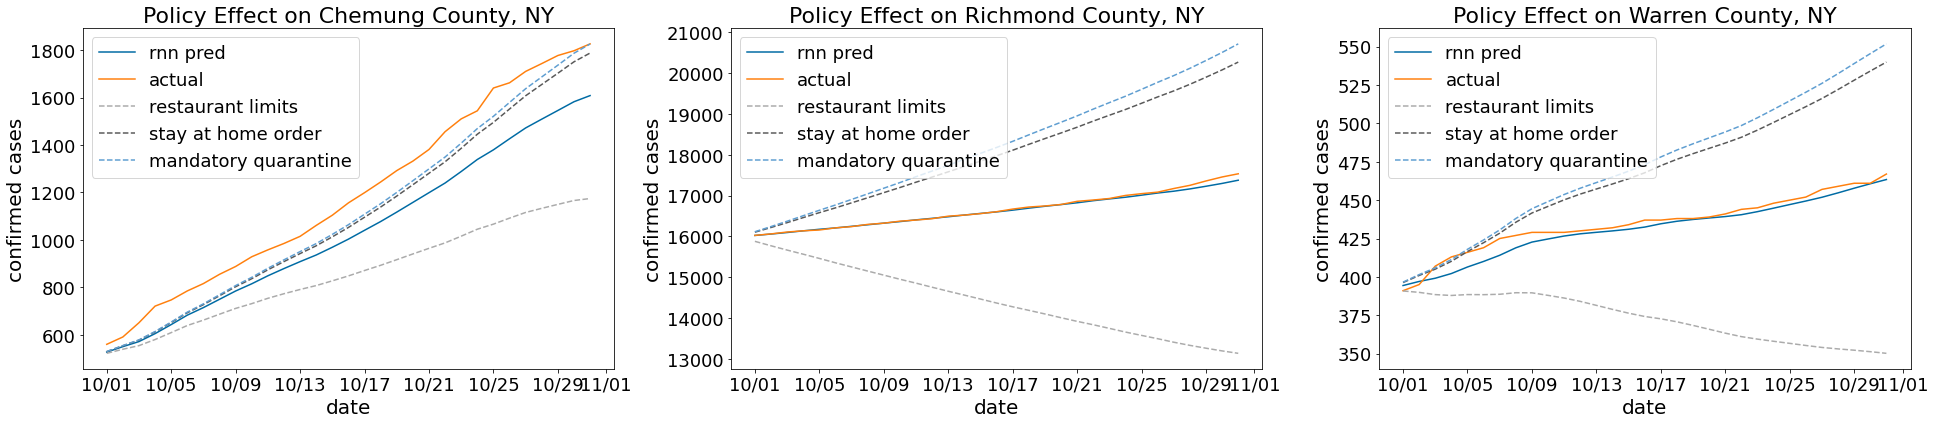

In [ ]:
draw_policy_effect_graph(pos_counties_total, predictions[0], "positive", 3)
draw_policy_effect_graph(neg_counties_total, predictions[0], "negative", 3)